In [1]:
# importing required modules
import torch as T 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# load the data and split into train and test
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])

# train set
trainset = datasets.FashionMNIST('Data/', download=True, train=True, transform=transform)
trainloader = T.utils.data.DataLoader(trainset, batch_size=128, shuffle=True )

# test set
testset = datasets.FashionMNIST('Data/',download=True, train = False, transform = transform)
testloader = T.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

    
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


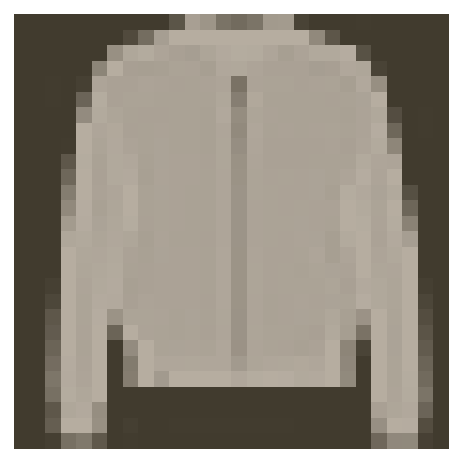

In [4]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

In [5]:
image.shape

torch.Size([128, 1, 28, 28])

In [6]:
class Classifier(nn.Module):
    # Deining layers
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(784,600)
        self.hidden1 = nn.Linear(600,400)
        self.hidden2 = nn.Linear(400,200)
        self.hidden3 = nn.Linear(200,100)
        self.output_layer = nn.Linear(100,10)

    # forward pass through the network
    def forward(self, x):
        first_layer = self.input_layer(x)
        act1 = F.relu(first_layer)
        second_layer = self.hidden1(act1)
        act2 = F.relu(second_layer)
        third_layer = self.hidden2(act2)
        act3 = F.relu(third_layer)
        fourth_layer = self.hidden3(act3)
        act4 = F.relu(fourth_layer)
        out_layer = self.output_layer(act4)
        #x = F.softmax(out_layer, dim=1)
        return out_layer
    
model = Classifier()
model

Classifier(
  (input_layer): Linear(in_features=784, out_features=600, bias=True)
  (hidden1): Linear(in_features=600, out_features=400, bias=True)
  (hidden2): Linear(in_features=400, out_features=200, bias=True)
  (hidden3): Linear(in_features=200, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
)

In [7]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [9]:
epochs = 20
print_every = 40

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):


        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        logits = model.forward(images)   # 1) Forward pass
        pred = F.log_softmax(logits, dim=1)
        loss = criterion(pred, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
        


Epoch: 1/20
	Iteration: 0	 Loss: 0.0579
	Iteration: 40	 Loss: 2.3046
	Iteration: 80	 Loss: 2.3025
	Iteration: 120	 Loss: 2.3030
	Iteration: 160	 Loss: 2.3007
	Iteration: 200	 Loss: 2.2973
	Iteration: 240	 Loss: 2.2964
	Iteration: 280	 Loss: 2.2937
	Iteration: 320	 Loss: 2.2936
	Iteration: 360	 Loss: 2.2888
	Iteration: 400	 Loss: 2.2884
	Iteration: 440	 Loss: 2.2847
Epoch: 2/20
	Iteration: 0	 Loss: 0.0570
	Iteration: 40	 Loss: 2.2810
	Iteration: 80	 Loss: 2.2762
	Iteration: 120	 Loss: 2.2749
	Iteration: 160	 Loss: 2.2713
	Iteration: 200	 Loss: 2.2656
	Iteration: 240	 Loss: 2.2624
	Iteration: 280	 Loss: 2.2589
	Iteration: 320	 Loss: 2.2546
	Iteration: 360	 Loss: 2.2485
	Iteration: 400	 Loss: 2.2442
	Iteration: 440	 Loss: 2.2373
Epoch: 3/20
	Iteration: 0	 Loss: 0.0557
	Iteration: 40	 Loss: 2.2262
	Iteration: 80	 Loss: 2.2121
	Iteration: 120	 Loss: 2.2046
	Iteration: 160	 Loss: 2.1962
	Iteration: 200	 Loss: 2.1790
	Iteration: 240	 Loss: 2.1614
	Iteration: 280	 Loss: 2.1417
	Iteration: 320	

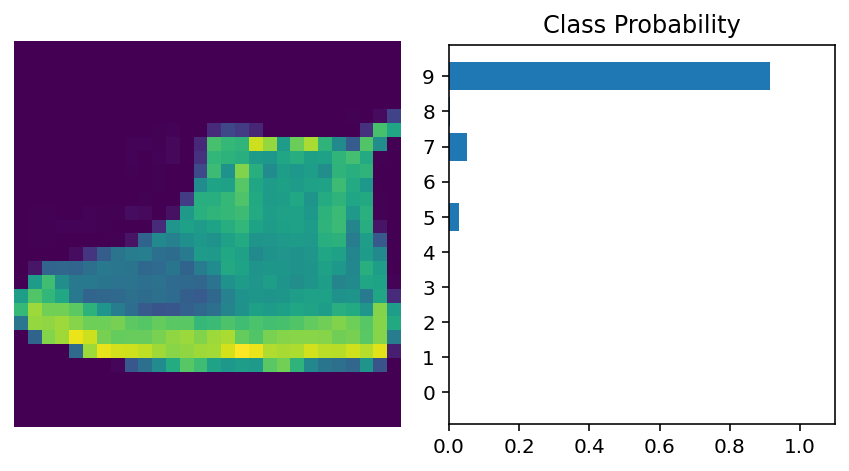

In [11]:
images, labels = next(iter(testloader))

img = images[48].view(1,784)
# Turn off gradients to speed up this part
with T.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps)